# Assignment 2: Working with health data from wearables

## Data

In this assigment you will use the [Daily Sports and Activities](http://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities) dataset from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html). This dataset contains motion sensor data of 19 daily and sports activities (walking, running, rowing, jumping,...), each performed by 8 subjects in their own style for 5 minutes. Five Xsens MTx units are used on the torso, (right and left) arms, and (right and left) legs. 

----

## Objectives

- Understand time-series health data
- Perform pre-processing and visualisation on time-series data
- Extract features from time-series data
- Train a classifier to predict the activity the users are doing

----

## Exercise 1

Load, analyse and visualise the (temporal) data of the different sensors for subject 7 (p7). Compare walking on a treadmill with a speed of 4 km/h on a flat surface (a10) and running on a treadmill with a speed of 8 km/h (a12). Do you see any difference? Comment.
 

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score, learning_curve, GridSearchCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

%matplotlib inline

In [87]:
# Your solution here:

# load info p7 a10 and p7 a12
a10 = pd.read_csv('data/a10/p7/s01.txt', header = None)
a12 = pd.read_csv('data/a12/p7/s01.txt', header = None)

# 45 columns correspond to --> 
#     T, RA, LA, RL, LL (torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL))
#    (each of them have 9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers))

In [88]:
def names_col(df):
    # Define column names
    column_names = []
    units = ['T', 'RA', 'LA', 'RL', 'LL']
    sensors = ['acc', 'gyro', 'mag']
    axes = ['x', 'y', 'z']

    # Generate column names
    for unit in units:
        for sensor in sensors:
            for axis in axes:
                column_names.append(f"{unit}_{sensor}{axis}")

    # Assign column names to DataFrame
    df.columns = column_names
    return(df)

In [89]:
a10 = names_col(a10)

In [95]:
a10

,T_accx,T_accy,T_accz,T_gyrox,T_gyroy,T_gyroz,T_magx,T_magy,T_magz,RA_accx,...,RL_magz,LL_accx,LL_accy,LL_accz,LL_gyrox,LL_gyroy,LL_gyroz,LL_magx,LL_magy,LL_magz
0,20.6030,-1.37780,8.620100,1.898000,0.26148,-0.30337,-0.90140,0.212530,-0.57884,2.9180,...,-0.088492,-23.9930,-0.36275,5.10250,-0.297260,1.07470,-3.338500,0.95984,0.41179,0.099259
1,45.3020,-6.08260,5.553900,2.168700,-2.55130,1.55800,-0.99409,0.132640,-0.46885,5.7983,...,-0.029506,-24.3200,7.54730,1.39820,0.210720,0.79575,-3.938800,0.86717,0.52657,0.160060
2,13.6200,3.49220,-0.398390,3.387100,4.34650,-0.35181,-0.96845,0.115660,-0.50603,2.8863,...,-0.049180,-15.1510,7.86050,2.10670,-0.221400,0.85463,-3.304700,0.75126,0.63382,0.205570
3,7.6722,-0.92661,6.943400,1.982300,-0.21781,-0.52051,-0.91089,0.050433,-0.58311,5.3755,...,0.006264,-10.7170,6.52490,4.29950,0.301230,0.52825,-1.056100,0.69343,0.68394,0.195210
4,6.4156,-2.28970,0.180840,-0.932620,0.60615,0.46005,-0.87487,0.039289,-0.60690,4.8349,...,0.080915,-2.4467,13.19200,0.63253,4.978500,0.13100,0.598980,0.69825,0.70404,0.078655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,-2.4187,5.15980,0.072771,-1.132900,-1.47050,-0.55062,-0.85137,0.025532,-0.61919,3.9992,...,0.089762,-7.1889,-17.40700,7.43360,2.561600,-0.28095,-0.011209,0.79724,0.64187,-0.009413
121,-3.2808,2.62610,-5.582800,-1.547200,-2.46480,-1.27790,-0.91389,0.006872,-0.54343,2.2896,...,0.021329,-7.2190,-14.94000,2.76340,0.011921,0.52484,1.326300,0.79832,0.64325,-0.001533
122,6.9733,2.30320,-12.132000,2.661000,0.18712,-1.17160,-0.96479,-0.005082,-0.48350,4.1475,...,-0.002524,-13.1500,46.98700,-11.49700,0.692420,0.72658,-0.354590,0.77867,0.67238,0.089797
123,19.4150,1.90070,0.634900,-0.063856,1.61850,-0.57221,-0.98098,-0.058400,-0.48282,2.9000,...,-0.068783,-15.4080,7.93040,-0.63745,-2.052500,-0.33495,4.157600,0.83842,0.61181,0.139110


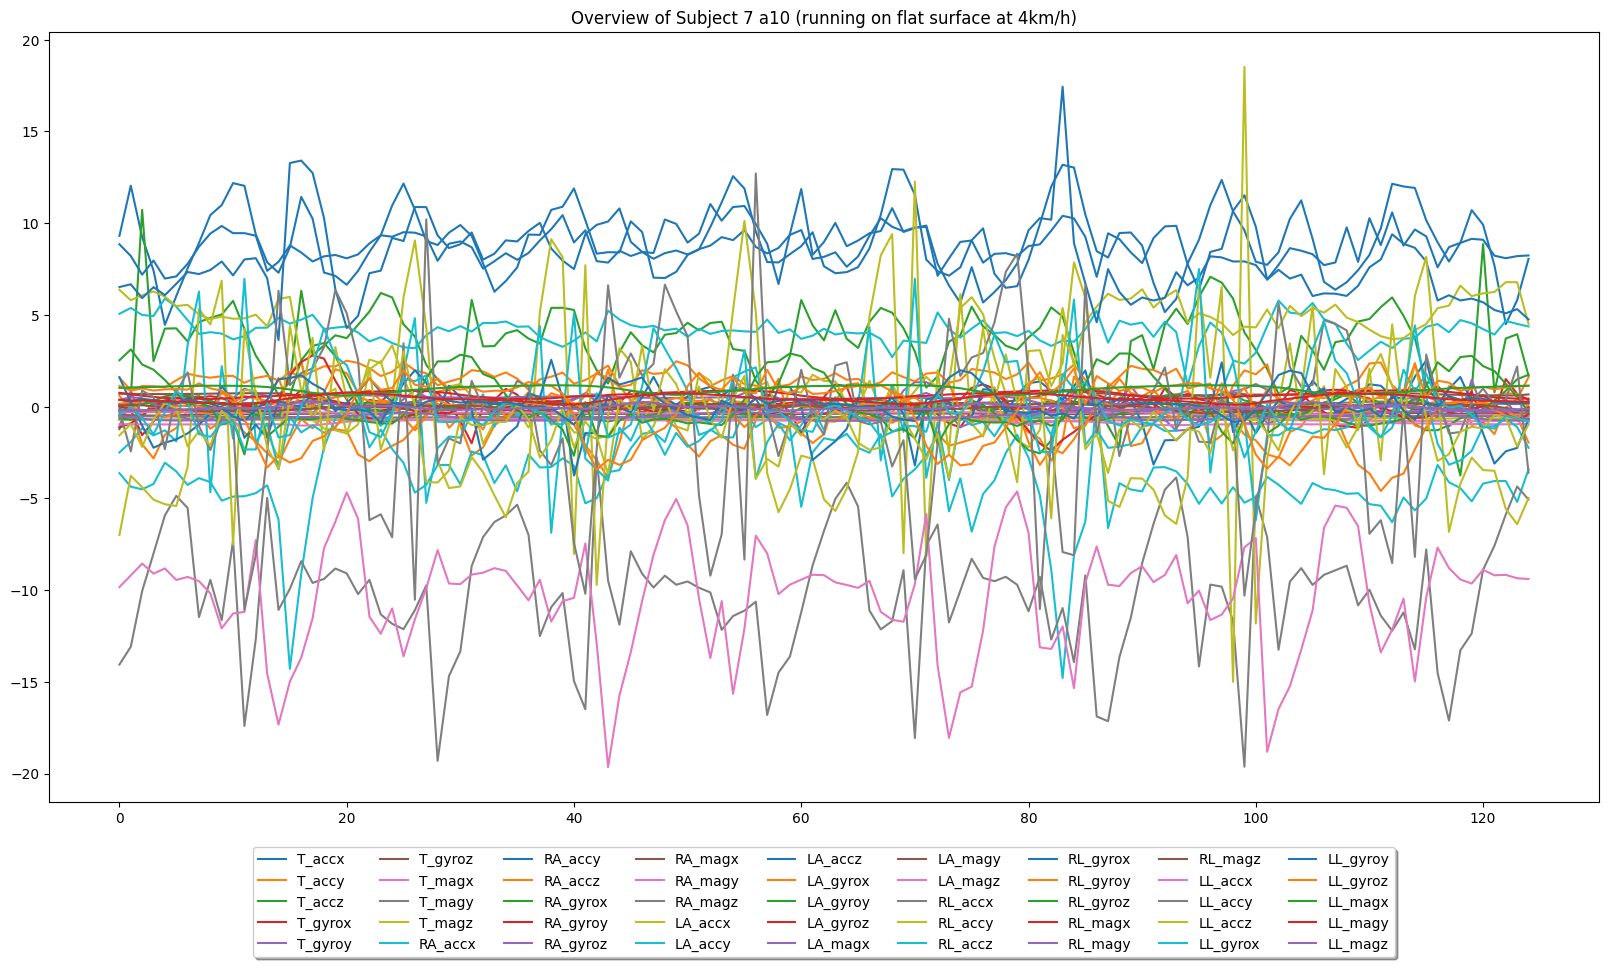

In [53]:
a10.plot(figsize=(20,10), legend = True)
plt.title('Overview of Subject 7 a10 (running on flat surface at 4km/h)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=9)
plt.show()

In [94]:
a12 = names_col(a12)

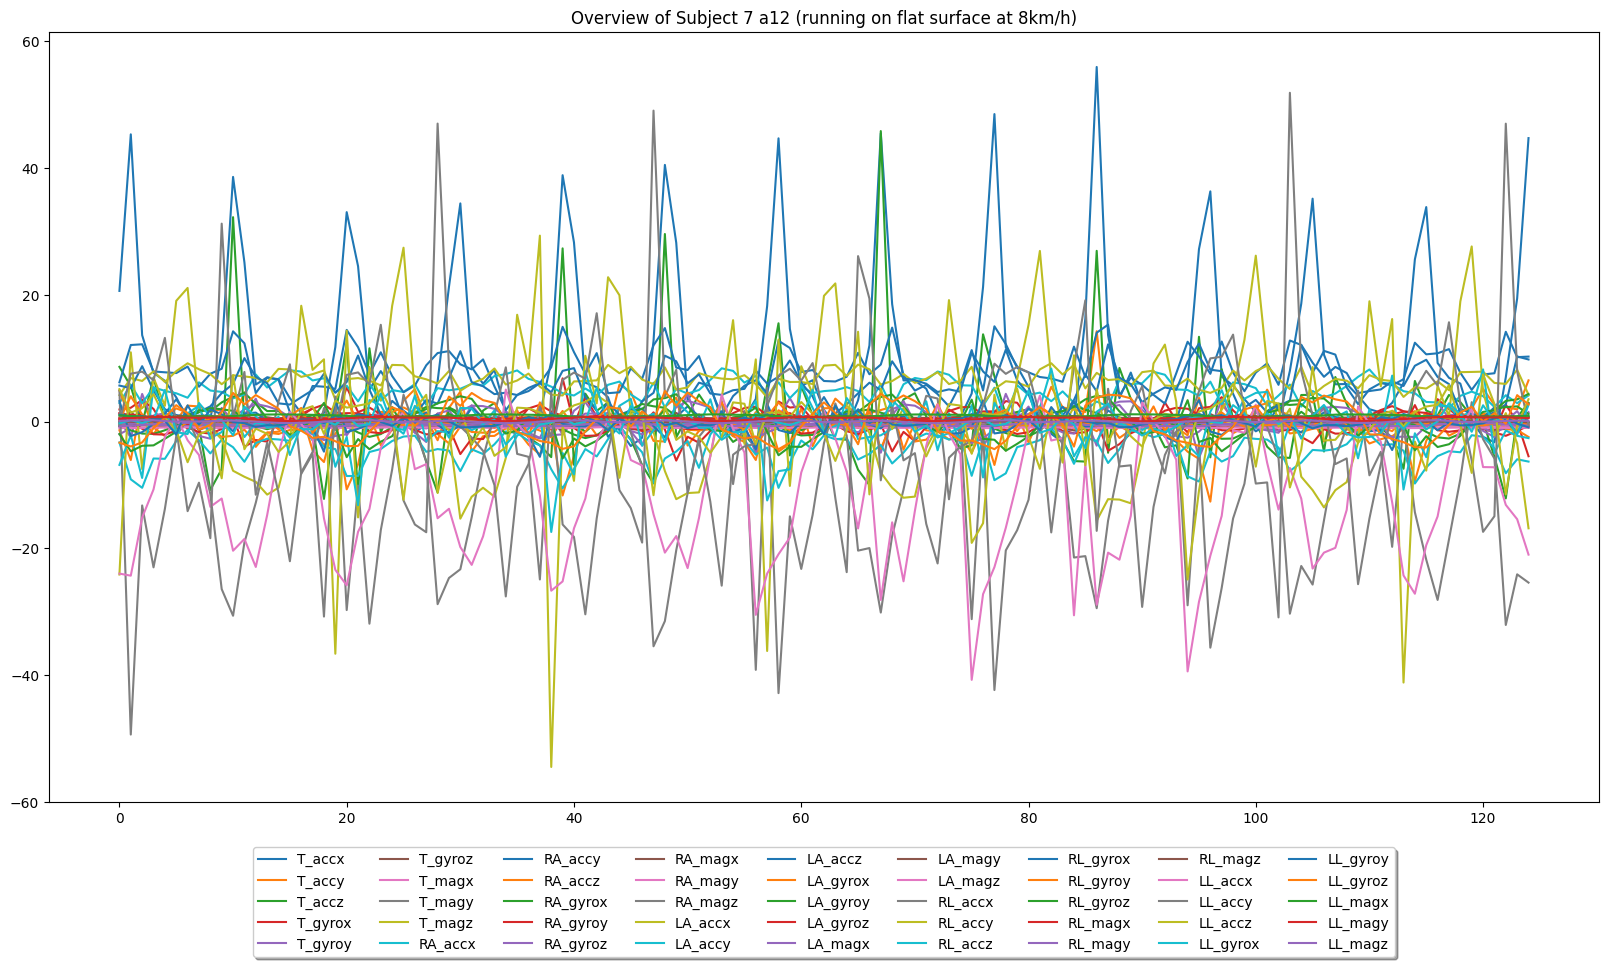

In [55]:
a12.plot(figsize=(20,10), legend = True)
plt.title('Overview of Subject 7 a12 (running on flat surface at 8km/h)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=9)
plt.show()

We have too much information, it would be better to do the comaprison separating by time of metric (acc, geo, mag) and where the metric is being taken from

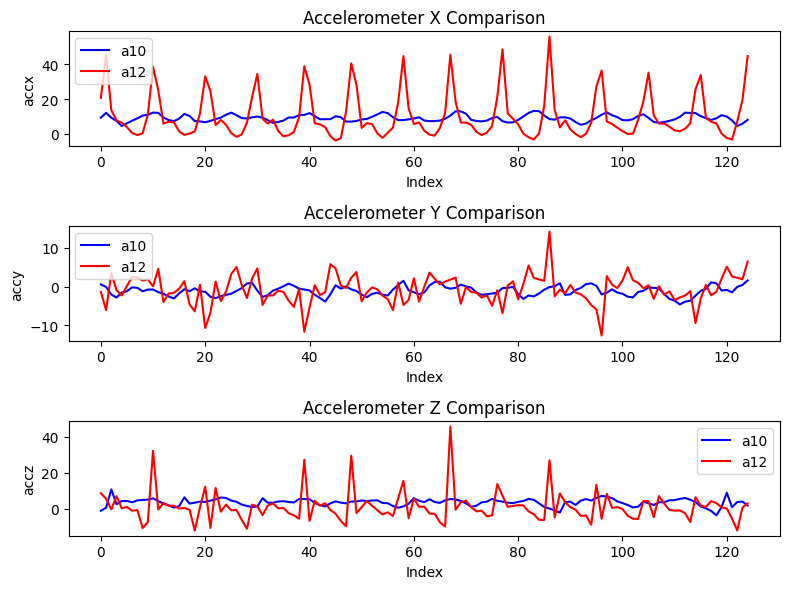

In [57]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))

# Plotting x
axes[0].plot(a10['T_accx'], label='a10', color='blue')
axes[0].plot(a12['T_accx'], label='a12', color='red')
axes[0].set_title('Accelerometer X Comparison')
axes[0].set_ylabel('accx')

# Plotting y
axes[1].plot(a10['T_accy'], label='a10', color='blue')
axes[1].plot(a12['T_accy'], label='a12', color='red')
axes[1].set_title('Accelerometer Y Comparison')
axes[1].set_ylabel('accy')

# Plotting z
axes[2].plot(a10['T_accz'], label='a10', color='blue')
axes[2].plot(a12['T_accz'], label='a12', color='red')
axes[2].set_title('Accelerometer Z Comparison')
axes[2].set_ylabel('accz')

# Adding common labels
for ax in axes:
    ax.set_xlabel('Index')
    ax.legend()

    plt.tight_layout()
plt.show()

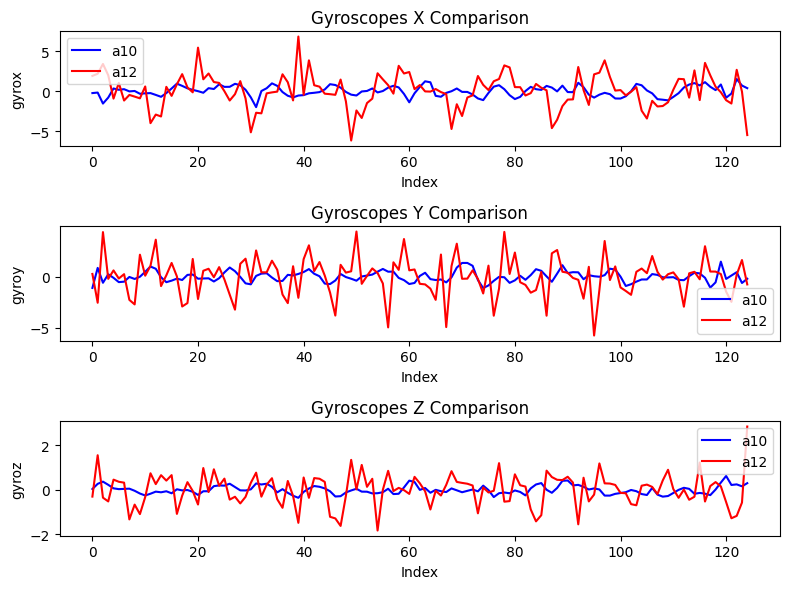

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))

# Plotting x
axes[0].plot(a10['T_gyrox'], label='a10', color='blue')
axes[0].plot(a12['T_gyrox'], label='a12', color='red')
axes[0].set_title('Gyroscopes X Comparison')
axes[0].set_ylabel('gyrox')

# Plotting y
axes[1].plot(a10['T_gyroy'], label='a10', color='blue')
axes[1].plot(a12['T_gyroy'], label='a12', color='red')
axes[1].set_title('Gyroscopes Y Comparison')
axes[1].set_ylabel('gyroy')

# Plotting z
axes[2].plot(a10['T_gyroz'], label='a10', color='blue')
axes[2].plot(a12['T_gyroz'], label='a12', color='red')
axes[2].set_title('Gyroscopes Z Comparison')
axes[2].set_ylabel('gyroz')

# Adding common labgyro
for ax in axes:
    ax.set_xlabel('Index')
    ax.legend()

    plt.tight_layout()
plt.show()

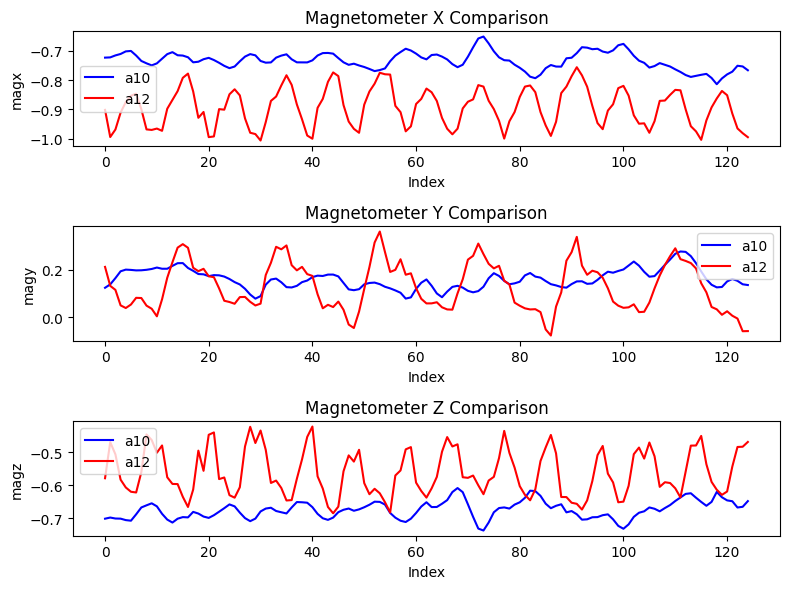

In [59]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))

# Plotting x
axes[0].plot(a10['T_magx'], label='a10', color='blue')
axes[0].plot(a12['T_magx'], label='a12', color='red')
axes[0].set_title('Magnetometer X Comparison')
axes[0].set_ylabel('magx')

# Plotting y
axes[1].plot(a10['T_magy'], label='a10', color='blue')
axes[1].plot(a12['T_magy'], label='a12', color='red')
axes[1].set_title('Magnetometer Y Comparison')
axes[1].set_ylabel('magy')

# Plotting z
axes[2].plot(a10['T_magz'], label='a10', color='blue')
axes[2].plot(a12['T_magz'], label='a12', color='red')
axes[2].set_title('Magnetometer Z Comparison')
axes[2].set_ylabel('magz')

# Adding common labgyro
for ax in axes:
    ax.set_xlabel('Index')
    ax.legend()

    plt.tight_layout()
plt.show()

These comparisons where only for the different torso entries, as there are 4 other parts of the body to analyse, I have selected some directions (x,y,z) that i thought where more important

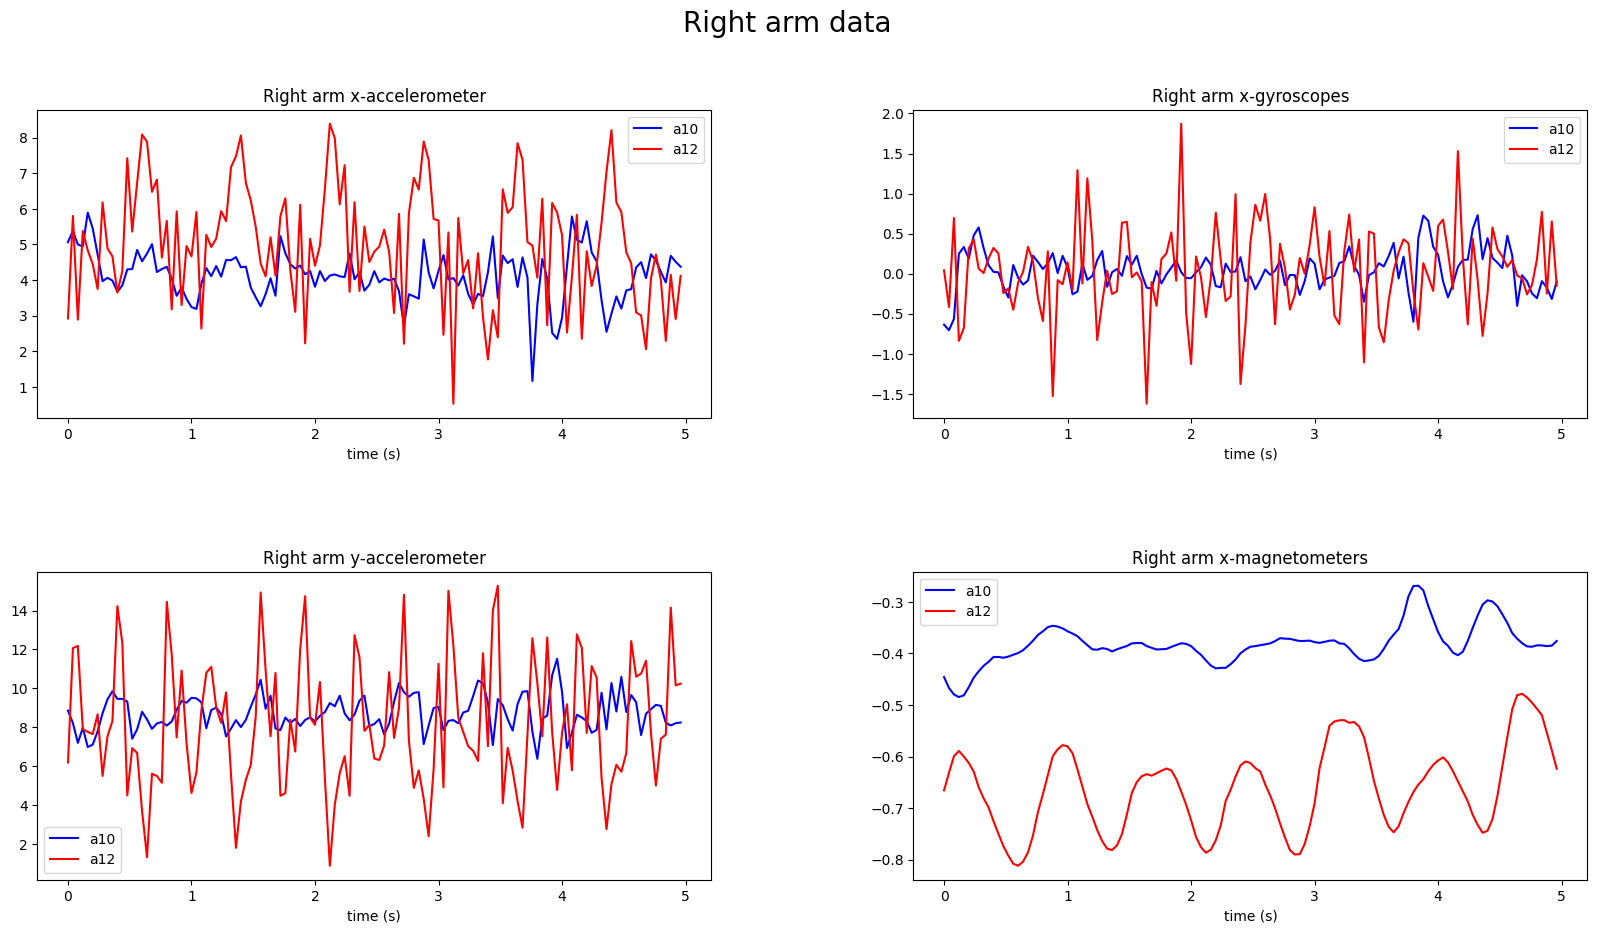

In [106]:
# 5-sec window for the right arm
arr = np.arange(0.0, 5.0 ,0.04 )

# Create a figure object and an array of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# General title to the figure
fig.suptitle('Right arm data', fontsize=20)

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# RA x-accelerometer
axs[0,0].plot(arr,a10['RA_accx'].values, label='a10', color='blue')
axs[0,0].plot(arr,a12['RA_accx'].values, label='a12', color='red')
axs[0,0].legend()
axs[0,0].set_title('Right arm x-accelerometer')
axs[0,0].set_xlabel('time (s)')

# RA y-accelerometer
axs[1,0].plot(arr,a10['RA_accy'].values, label='a10', color='blue')
axs[1,0].plot(arr,a12['RA_accy'].values, label='a12', color='red')
axs[1,0].legend()
axs[1,0].set_title('Right arm y-accelerometer')
axs[1,0].set_xlabel('time (s)')

# RA x-gyroscopes
axs[0,1].plot(arr,a10['RA_gyrox'].values, label='a10', color='blue')
axs[0,1].plot(arr,a12['RA_gyrox'].values, label='a12', color='red')
axs[0,1].legend()
axs[0,1].set_title('Right arm x-gyroscopes')
axs[0,1].set_xlabel('time (s)')

# RA x-magnetometers
axs[1,1].plot(arr,a10['RA_magx'].values, label='a10', color='blue')
axs[1,1].plot(arr,a12['RA_magx'].values, label='a12', color='red')
axs[1,1].legend()
axs[1,1].set_title('Right arm x-magnetometers')
axs[1,1].set_xlabel('time (s)')

plt.show()

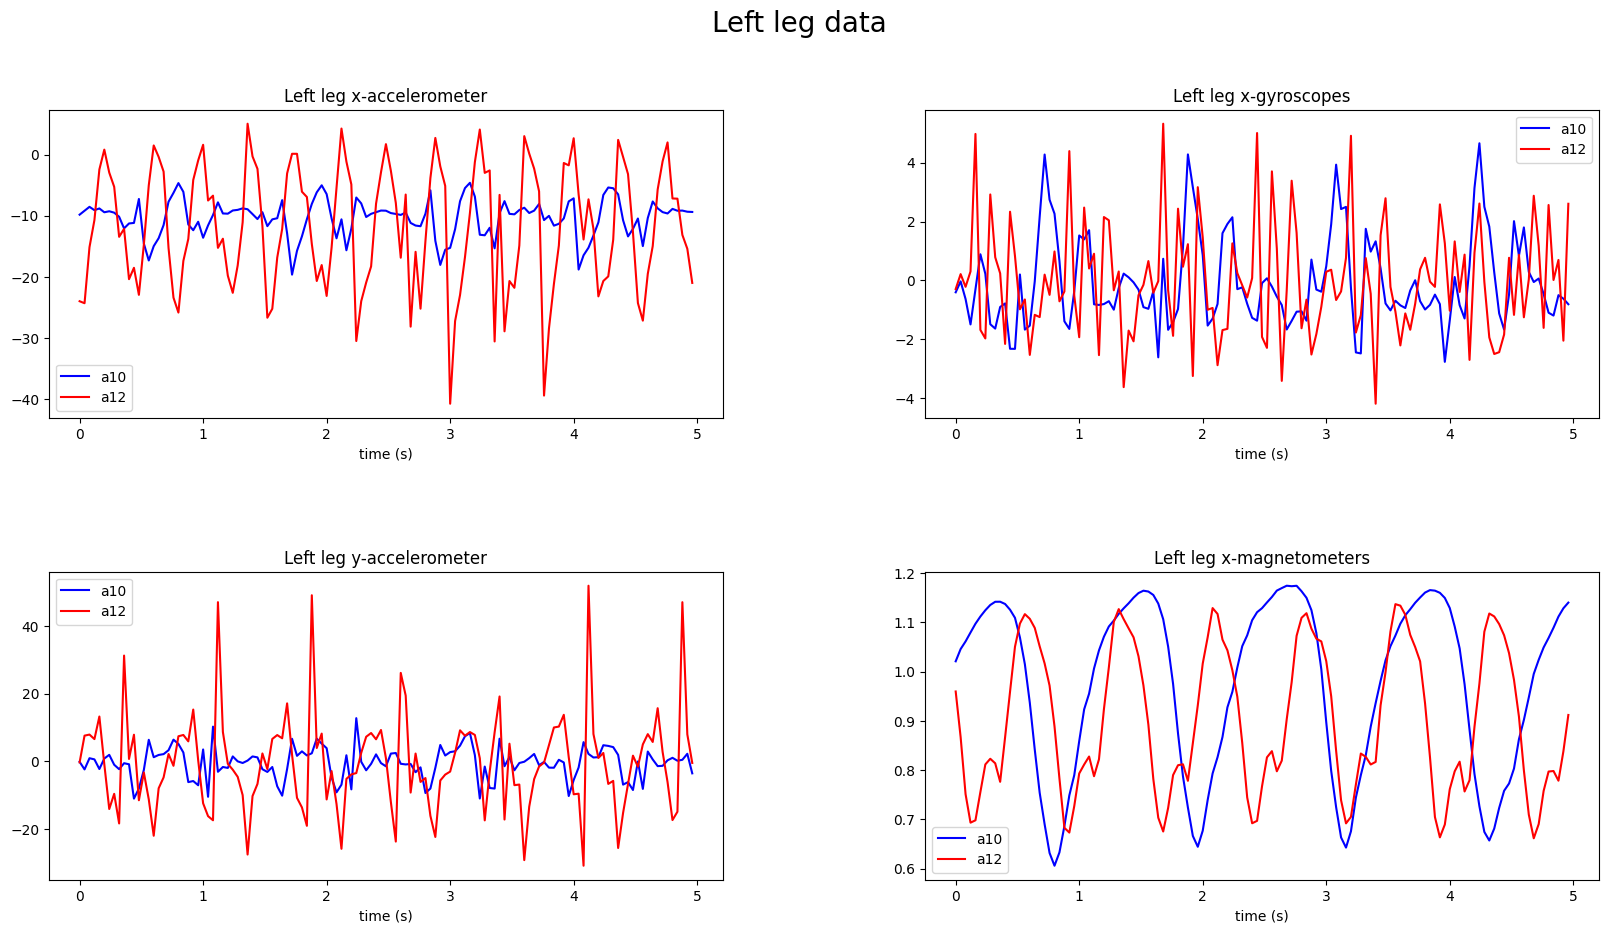

In [100]:
# 5-sec window for the left leg
arr = np.arange(0.0, 5.0 ,0.04 )

# Create a figure object and an array of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# General title to the figure
fig.suptitle('Left leg data', fontsize=20)

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# LL x-accelerometer
axs[0,0].plot(arr,a10['LL_accx'].values, label='a10',color='blue')
axs[0,0].plot(arr,a12['LL_accx'].values, label='a12', color='red')
axs[0,0].legend()
axs[0,0].set_title('Left leg x-accelerometer')
axs[0,0].set_xlabel('time (s)')

# LL y-accelerometer
axs[1,0].plot(arr,a10['LL_accy'].values, label='a10',color='blue')
axs[1,0].plot(arr,a12['LL_accy'].values, label='a12', color='red')
axs[1,0].legend()
axs[1,0].set_title('Left leg y-accelerometer')
axs[1,0].set_xlabel('time (s)')

# LL x-gyroscopes
axs[0,1].plot(arr,a10['LL_gyrox'].values, label='a10',color='blue')
axs[0,1].plot(arr,a12['LL_gyrox'].values, label='a12',color='red')
axs[0,1].legend()
axs[0,1].set_title('Left leg x-gyroscopes')
axs[0,1].set_xlabel('time (s)')

# LL x-magnetometers
axs[1,1].plot(arr,a10['LL_magx'].values, label='a10', color='blue')
axs[1,1].plot(arr,a12['LL_magx'].values, label='a12', color='red')
axs[1,1].legend()
axs[1,1].set_title('Left leg x-magnetometers')
axs[1,1].set_xlabel('time (s)')

plt.show()


Comparing of the same subject doing different activities it seems as activity a12 is more phisically demanding than a10. Notice how the oscilations over time for the 3 coordinates on all points of measurements reach bigger expremes in a12 (running on a treadmill with speed of 8km/h) rather than in a10 which corresponds on walking in a treadmill with a speed of 4 km/h.

## Exercise 2

Build a model (classifier) to predict the activity of a given subject. Decide on which features could be extracted from the data. For example:

- **mean, variance,skewness, and the kurtosis**. The distribution of each signal are approximately Normal. This means that we can take the first four statistical moments for each 5 second segment. By including the four moments, we are helping our models better learn the characteristic of each unique activity. 
- n first values of the  the  [**autocorrelation**](https://en.wikipedia.org/wiki/Autocorrelation) sequence. In some time series analyses, such as in [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), it is desirable to minimize autocorrelation so as to transform the series into a [stationary state](https://en.wikipedia.org/wiki/Stationary_process). 
- n peaks of the [**discrete Fourier transform**](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)
of a segment with the corresponding frequencies.

Consider normalising all features between [0,1] and reduce the dimension of features using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).


We propose 2 approaches to create your train/testing set.

(1) Train and test sets that contain shuffled samples from each user. So the model will train on data from every user and predict the activities from every user in the test set.
(2) Seven user's data will be used as the training set and only one user's data as the test set. The goal here is to predict the activities of a user that the model has never seen before. How good is the model generalising the problem?

For each approach, consider the following building framework:
1. Split data into train and holdout sets
2. Optimize model hyperparameters
3. Cross Validate model's performance by analyze learning curves

Finally, consider the follwing evaluation metrics:

**Accuracy** represents how close or far off a given set of measurements are to their true value.

**Precision**: percentage of classifications predicted to be positive are actually positive. **Precision is a measure of the failure to correctly predict positive classifications. **

$$\textbf{Precision} = \frac{TP}{TP + FP}, $$

where TP refers to True Positives and FP to False Positives. 

**Recall** describes how well the model can identify points that belong to the positive class. **Recall is a measure of the failure in distinguishing between positive and negative classifications. **

$$\textbf{Recall} = \frac{TP}{TP + FN},$$

where FN corresponds to False Negatives.

Finally, the $f_{1} score$ is a weighted average of precision and recall. The  $f_{1} score$  is used to get a measure of both types of failures.

**Note: Make comments on the code to discuss the results.**
 

In [60]:
# Your solution here:

First  compute mean, variance, skewness, Kurtosis and autocorrelation for each 5-seconds segment of a sensor, for every subject and for any activity. We will create a dataframe with (45 x 5)=225 columns and (19x8 x 60) = 9120 rows.

In [61]:
# Create an empty dataframe with the desire columns
def create_columns_extra(df):
    columns = []
    statistic = ['mean','var','ske','kurt','autocorr']
    units = ["T","RA","LA","RL","LL"]
    axis = ["x","y","z"]
    sensor = ["acc","gyro","mag"]
    for stat in statistic:
        for unit in units:
            for sens in sensor:
                for ax in axis:
                    name_col = "{}_{}{}_{}".format(unit, ax, sens, stat)
                    columns.append(name_col)
    
    df.columns = columns
df_final = pd.DataFrame(columns=range(225))
create_columns_extra(df_final)

In [62]:
# Build the dataframe
activity_list = []

for i in range(1,20): # each activity
    for j in range(1,9):# each subject
        for filename in os.listdir('data/a'+str(i).zfill(2)+'/p'+str(j)):# each segment
            directory = 'data/a'+str(i).zfill(2)+'/p'+str(j)
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath,header = None)# read each txt file
            
            # Statistical computations
            segment_mean = df.mean(axis = 0).tolist() # mean
            segment_variance = df.var(axis = 0).tolist()# variance
            segment_skewness = df.skew(axis = 0).tolist()# skewness
            segment_kurtosis = df.kurtosis(axis = 0).tolist()# kurtosis
            segment_autocorr = df.apply(lambda col: col.autocorr(lag=1), axis=0).tolist()# autocorrelation
    
            # Create a unic list
            segment_mean.extend(segment_variance)
            segment_mean.extend(segment_skewness)
            segment_mean.extend(segment_kurtosis)
            segment_mean.extend(segment_autocorr)
            
            # Append the final row to our dataframe
            df_final.loc[len(df_final)] = segment_mean
            
            # Actualize the activity list
            activity_list.append(i)
            
# Create the target column using the activity_list
df_final['activity'] = activity_list

In [63]:
df_final

,T_xacc_mean,T_yacc_mean,T_zacc_mean,T_xgyro_mean,T_ygyro_mean,T_zgyro_mean,T_xmag_mean,T_ymag_mean,T_zmag_mean,RA_xacc_mean,...,LL_xacc_autocorr,LL_yacc_autocorr,LL_zacc_autocorr,LL_xgyro_autocorr,LL_ygyro_autocorr,LL_zgyro_autocorr,LL_xmag_autocorr,LL_ymag_autocorr,LL_zmag_autocorr,activity
0,7.978250,1.140865,5.598922,0.003308,0.022514,-0.003240,-0.791962,-0.070157,0.137123,0.644964,...,0.272134,0.004292,0.494905,0.028671,-0.109248,0.098514,0.096706,-0.040019,0.044699,1
1,7.848294,1.461678,5.706690,0.001463,0.016896,-0.002703,-0.789926,-0.078135,0.125666,0.164340,...,0.339590,0.112416,0.090285,0.009658,-0.070584,0.191251,-0.054379,0.018801,-0.001302,1
2,7.822188,1.482432,5.728115,0.003867,0.023562,-0.003863,-0.790796,-0.078869,0.122690,0.128382,...,0.187621,0.029316,0.243099,0.151828,-0.057836,0.039934,-0.036899,0.172178,0.035848,1
3,7.892409,1.423223,5.656550,0.003427,0.021218,-0.003311,-0.789013,-0.075992,0.130639,0.198383,...,0.242876,0.031062,0.133367,0.028205,0.030899,-0.175498,-0.280019,-0.008156,0.079576,1
4,7.849953,1.295031,5.752277,0.001578,0.021106,-0.004075,-0.790812,-0.076835,0.121812,0.379130,...,0.274641,0.036395,0.293464,-0.027210,-0.038526,0.215885,-0.130312,-0.019341,-0.132691,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,9.187627,-0.088365,-0.631394,-0.119521,0.089736,-0.098563,-0.711321,-0.466081,-0.122249,6.346958,...,0.465710,0.496042,0.143943,0.648549,0.688702,0.836201,0.957701,0.962531,0.926307,19
9116,9.468289,-0.333723,0.639205,0.043480,0.048001,-0.035477,-0.706111,-0.420412,-0.038388,6.962207,...,0.540925,0.150301,0.485500,0.723476,0.537792,0.819447,0.980414,0.987281,0.964465,19
9117,9.620594,-0.740396,1.409694,0.508840,0.018991,0.084511,-0.683581,0.309058,-0.215046,9.151859,...,0.297465,0.350479,0.328489,0.632966,0.643400,0.822088,0.986894,0.990345,0.989984,19
9118,9.250127,-0.509951,0.143130,-0.147384,0.034032,-0.016210,-0.640771,-0.249864,-0.376206,9.773671,...,0.584815,0.207859,0.294442,0.526850,0.270576,0.669522,0.978599,0.991670,0.975929,19


## Pre-processing
1) 1st approach for splitting training/test set
2) Normalizing the data between 0 and 1
3) Dimentionality reduction performing PCA

In [64]:
# Train/test split
X = df_final.iloc[:, :-1]
y = df_final['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, shuffle = True)

# Normalization of all features between [0,1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Dimensionality reduction selecting the components such that the amount of variance that needs to be explained is greater than 90%
pca = PCA(n_components = 0.9)
X_red = pca.fit_transform(X_train_scaled)
X_train_red = pd.DataFrame(X_red)

# Transform also the test set
X_test_red = pd.DataFrame(pca.transform(X_test_scaled))

In [65]:
X_train_red

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,-0.551494,-0.112706,-0.574830,-0.208374,0.312009,0.119023,0.086159,-0.366788,0.257640,-0.073911,...,0.102949,-0.054257,0.038902,-0.038110,-0.116896,0.052638,0.301866,0.012007,0.109942,-0.131888
1,1.343227,0.196731,-0.596123,1.017263,0.758830,-0.594957,-0.032229,0.009762,-0.274634,-0.296575,...,0.235674,0.133999,-0.083301,0.015871,-0.040524,-0.066205,0.028960,-0.050023,0.018998,0.125016
2,2.558525,0.741584,0.346847,0.273590,-0.181587,-0.157328,-0.384958,-0.135668,0.175219,0.411644,...,0.267581,0.085499,0.083400,0.066275,0.138712,-0.036854,0.017100,0.168096,0.083508,0.000738
3,3.057166,0.843149,0.440497,0.124346,-0.255773,-0.180618,-0.462635,-0.006968,0.303277,0.219120,...,0.005989,-0.112955,-0.066151,0.025713,-0.129078,0.103060,0.022379,-0.022207,0.040507,-0.033580
4,-0.274783,1.311316,0.049366,-0.023111,0.192557,0.721516,-0.319312,-0.030951,0.003577,-0.240013,...,0.001326,0.076569,-0.088769,-0.016642,-0.107261,-0.055682,-0.063025,0.056753,0.109414,0.034475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,-0.164524,-0.869762,1.213968,0.379319,0.183306,0.335058,0.318371,0.110544,-0.289165,-0.128137,...,-0.118350,-0.000618,-0.011705,0.148790,-0.055053,0.010030,-0.051011,-0.104043,-0.023506,0.062219
6380,-0.420232,-0.275103,0.537703,0.114716,-0.318024,-0.213627,-0.309683,-0.184017,-0.128229,0.036774,...,-0.037986,0.055537,-0.021537,-0.024647,-0.003855,0.051096,0.066069,-0.053175,0.007294,0.024694
6381,-0.246633,-0.637194,2.054129,0.276356,0.311226,0.281328,0.607042,0.205669,0.038052,-0.318702,...,0.059235,-0.119003,0.021909,0.058883,-0.127380,-0.169477,-0.132129,-0.037930,0.020865,0.092085
6382,0.523163,-0.508124,-0.411951,0.183028,0.076539,0.388441,-0.494248,-0.282730,-0.144085,-0.368204,...,-0.024890,0.002834,-0.010699,-0.063174,0.052625,0.045260,-0.070292,0.046895,0.163923,-0.021243


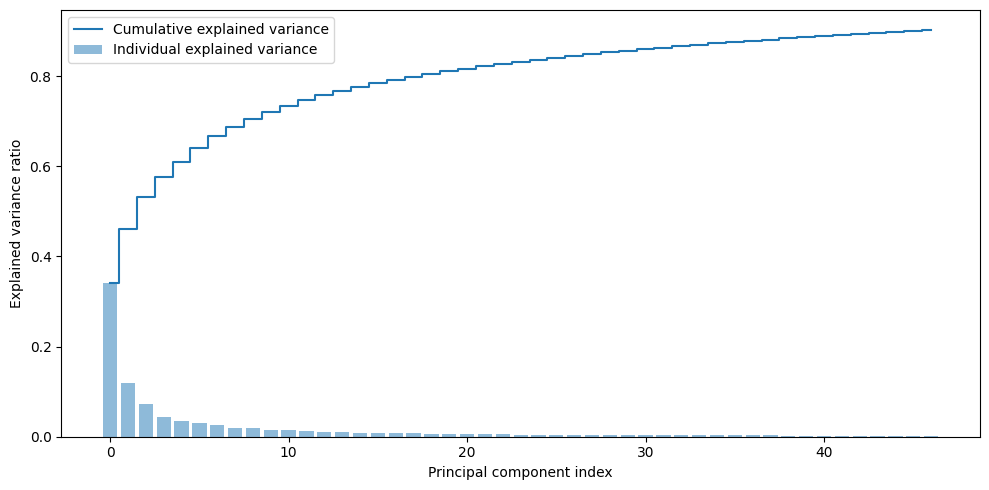

The total principal components needed such that the amount of variance that needs to be explained is greater than 90% are: 47


In [66]:
# plot PCA

# Determine explained variance 
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.figure(figsize=(10, 5))

# Plot the bar and step charts
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

# Set the axis labels and legend
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
# Adjust the spacing
plt.tight_layout()
plt.show()
print('The total principal components needed such that the amount of variance that needs to be explained is greater than 90% are:',len(exp_var_pca))

## Testing different models

In [71]:
from sklearn.model_selection import learning_curve

def Learning_Curve(clf, X, y):
    # Calculate the learning curve using cross-validation
    train_sizes, train_scores, test_scores = learning_curve(clf,
                                                            X, y, cv=5, scoring='accuracy',
                                                            train_sizes=np.linspace(0.01, 1.0, 50))
    
    # Calculate the mean and standard deviation of the training and testing scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.subplots(1, figsize=(8,8))
    plt.plot(train_sizes, train_mean, '--', color="black",  label="Training score")
    plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


### SVM

Lets try classification using super vector machine

In [102]:
# Train an SVM classifier
print('SUPPORT VECTOR MACHINES')
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_red, y_train)

# Predict the labels of the test set
y_pred = clf_svm.predict(X_test_red)

# Calculate the accuracy of the classifier
scores = cross_val_score(clf_svm, X_train_red, y_train, cv=5)
print("%0.5f mean accuracy of the cross validation with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

# Create taget names for the classification report
target = []
for i in range(1,20):
    target.append('a'+str(i).zfill(2))

print(classification_report(y_test, y_pred,target_names = target))

SUPPORT VECTOR MACHINES
0.98966 mean accuracy of the cross validation with a standard deviation of 0.00077
              precision    recall  f1-score   support

         a01       1.00      1.00      1.00       156
         a02       0.99      1.00      0.99       140
         a03       1.00      1.00      1.00       163
         a04       1.00      1.00      1.00       147
         a05       1.00      1.00      1.00       133
         a06       1.00      1.00      1.00       137
         a07       0.93      0.95      0.94       162
         a08       0.93      0.91      0.92       128
         a09       1.00      0.99      1.00       148
         a10       1.00      1.00      1.00       152
         a11       0.99      1.00      1.00       141
         a12       1.00      1.00      1.00       143
         a13       1.00      1.00      1.00       141
         a14       1.00      1.00      1.00       129
         a15       1.00      1.00      1.00       145
         a16       1.00     

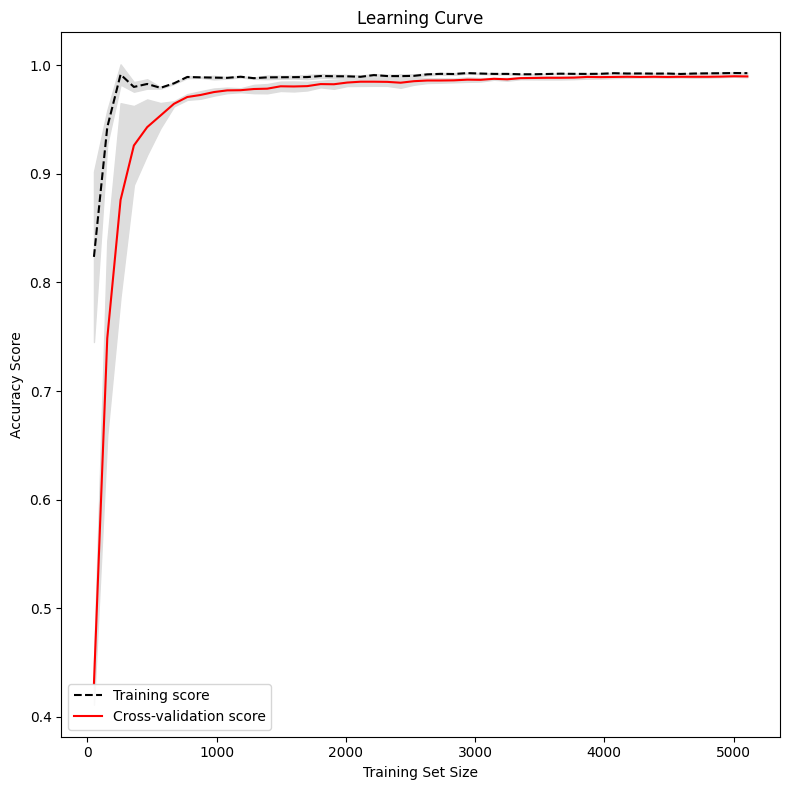

In [72]:
# Learning Curve
Learning_Curve(clf_svm,X_train_red,y_train)

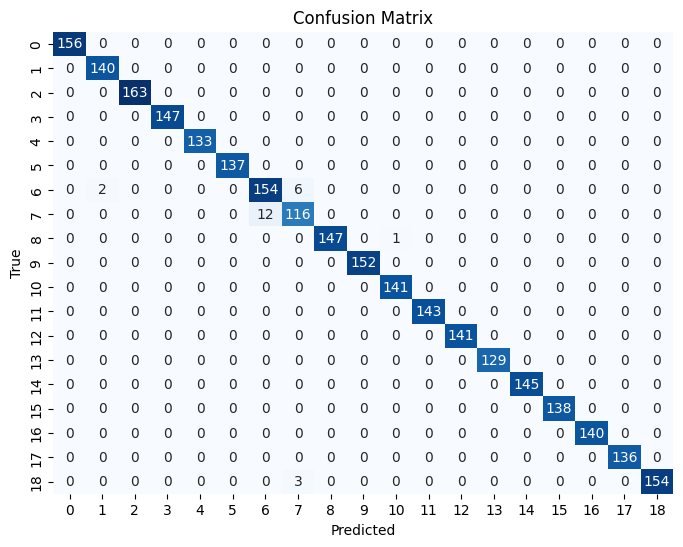

In [103]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### k-NN

In [104]:
# Train an KNN classifier
print('K-NEAREST NEIGHBORS')
# Choose the better k
neighbors_list = []
for n in range(3,10):
    clf_KN = KNeighborsClassifier(n_neighbors = n)
    clf_KN.fit(X_train_red, y_train)

    # Calculate the accuracy of every  classifier
    scores = cross_val_score(clf_KN, X_train_red, y_train, cv=5)
    print("%0.5f mean accuracy for k = %0.2f of the cross validation with a sd of %0.5f" % (scores.mean(),n, scores.std()))
    neighbors_list.append(scores.mean())
    
# Choose the better and use this as our classifier
best_k = neighbors_list.index(max(neighbors_list)) + 3
print('The best KNN classifier is perform by k =', best_k,'. Let us study this case')
clf_KN = KNeighborsClassifier(n_neighbors = best_k)
clf_KN.fit(X_train_red, y_train)

# Predict the labels of the test set
y_pred = clf_KN.predict(X_test_red)

# Create taget names for the classification report
target = []
for i in range(1,20):
    target.append('a'+str(i).zfill(2))

print(classification_report(y_test, y_pred,target_names = target))

K-NEAREST NEIGHBORS
0.98778 mean accuracy for k = 3.00 of the cross validation with a sd of 0.00162
0.98684 mean accuracy for k = 4.00 of the cross validation with a sd of 0.00115
0.98888 mean accuracy for k = 5.00 of the cross validation with a sd of 0.00104
0.98622 mean accuracy for k = 6.00 of the cross validation with a sd of 0.00153
0.98575 mean accuracy for k = 7.00 of the cross validation with a sd of 0.00104
0.98528 mean accuracy for k = 8.00 of the cross validation with a sd of 0.00259
0.98496 mean accuracy for k = 9.00 of the cross validation with a sd of 0.00218
The best KNN classifier is perform by k = 5 . Let us study this case
              precision    recall  f1-score   support

         a01       1.00      0.99      1.00       156
         a02       0.95      1.00      0.98       140
         a03       1.00      1.00      1.00       163
         a04       1.00      1.00      1.00       147
         a05       1.00      1.00      1.00       133
         a06       0.96   

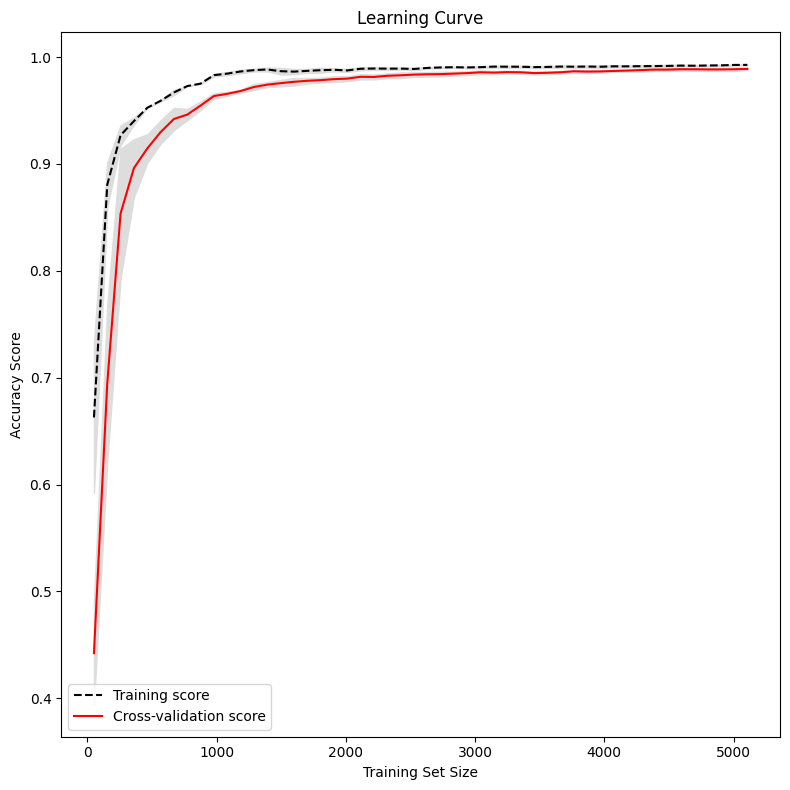

In [73]:
# Learning Curve
Learning_Curve(clf_KN,X_train_red,y_train)

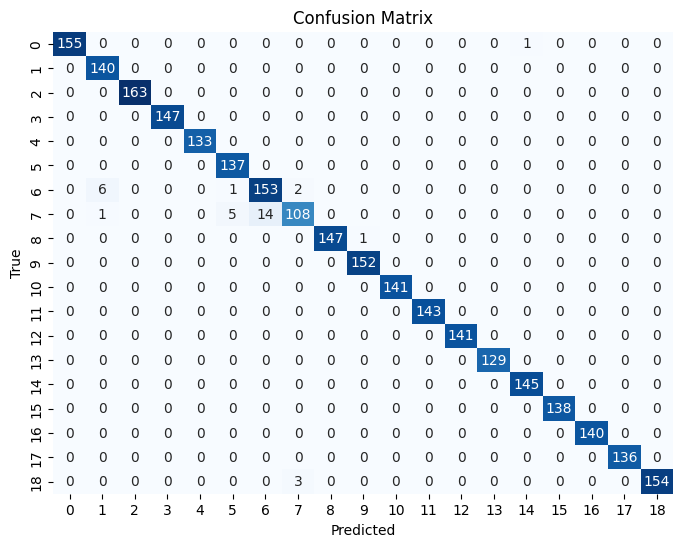

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### XG-boost
A much powerful classifier

In [81]:
# Train an XGB classifier
print('XGBOOST')
clf_xgb = xgb.XGBClassifier(random_state=42)
le = LabelEncoder()# needed for xgboost
y_train_xgb = le.fit_transform(y_train)
y_test_xgb = le.fit_transform(y_test)
clf_xgb.fit(X_train_red, y_train_xgb)

# Predict the labels of the test set
y_pred = clf_xgb.predict(X_test_red)

# Calculate the accuracy of the classifier
scores = cross_val_score(clf_xgb, X_train_red, y_train_xgb, cv=5)
print("%0.5f mean accuracy of the cross validation with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

# Create taget names for the classification report
target = []
for i in range(1,20):
    target.append('a'+str(i).zfill(2))

print(classification_report(y_test_xgb, y_pred,target_names = target))

XGBOOST
0.98340 mean accuracy of the cross validation with a standard deviation of 0.00207
              precision    recall  f1-score   support

         a01       1.00      0.99      1.00       156
         a02       0.98      0.99      0.99       140
         a03       1.00      0.99      0.99       163
         a04       1.00      0.99      0.99       147
         a05       0.99      0.99      0.99       133
         a06       0.99      1.00      0.99       137
         a07       0.93      0.94      0.94       162
         a08       0.89      0.91      0.90       128
         a09       1.00      0.97      0.99       148
         a10       0.97      0.97      0.97       152
         a11       0.97      0.99      0.98       141
         a12       0.99      1.00      0.99       143
         a13       1.00      1.00      1.00       141
         a14       1.00      0.99      1.00       129
         a15       0.99      1.00      1.00       145
         a16       1.00      1.00      1.00 

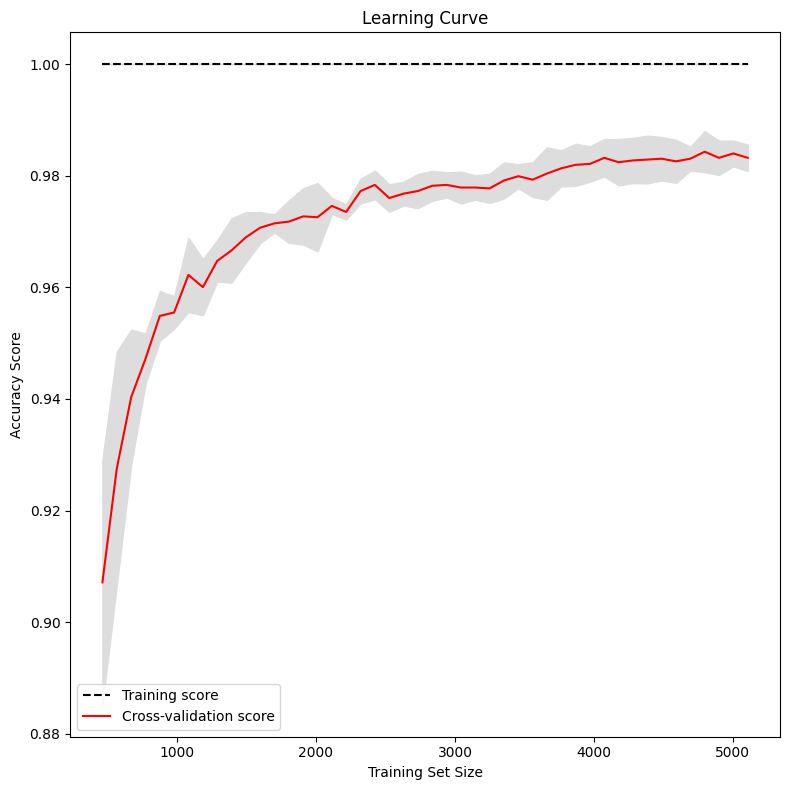

In [83]:
# Learning Curve
Learning_Curve(clf_xgb,X_train_red,y_train_xgb)

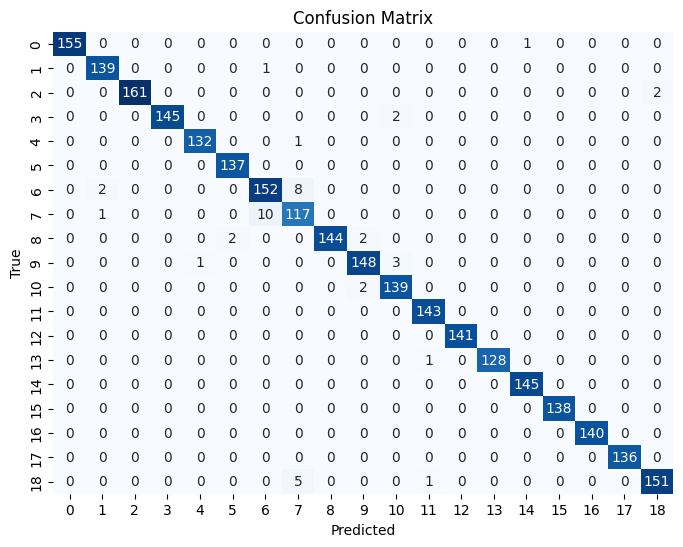

In [84]:
cm = confusion_matrix(y_test_xgb, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Summary of the results

In [101]:
data = {'Classifier': ['SVM', 'K-NN,k=3', 'XGboost'],
        'Mean-Accuracy': [0.98997, 0.98794, 0.98355],
        'Standard Deviation': [0.00181, 0.00283, 0.00210],
        'Precision':[0.99 ,0.99 ,0.98],
        'Recall':[0.99 ,0.99 ,0.98],
        'f1-score':[0.99, 0.99 ,0.98 ]}
pd.DataFrame(data)

,Classifier,Mean-Accuracy,Standard Deviation,Precision,Recall,f1-score
0,SVM,0.98997,0.00181,0.99,0.99,0.99
1,"K-NN,k=3",0.98794,0.00283,0.99,0.99,0.99
2,XGboost,0.98355,0.00210,0.98,0.98,0.98


We can see that SVM is a little bit better than the other two classifiers in terms of mean-accuracy. Taking also into account the execution time which is the fastes, I would select SVM as a good classifier for this type of problem.

Looking at the confucsion matrix of the 3 classifiers, all of them have the most trouble predicting correctly activity 7 (standing in an elevator) which is normally predicted as activity 6 (descending stairs). Maybe having added more statistical information such as ARIMA or using Fourier in order to know the number of peacks would have helped reduce this small errors that are in the current models, nevertheless the results are quite good.